- graphs starting quantities at zero
- graph prettiness
- reorganize to format of other notebooks
- store pvalues (done)
- conversation about type 1 and 2 errors
- ANOVA tukey graph, talk about CI

<img src='images/Northwind_ERD_updated.png.'>


# Initial Question

### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

# Initial Hypothesis

### H0: no effect - **discount** has no effect on **quantity** of a **product** in an **order**

### HA: effect - discount has statistically significant effect on quantity of a product in an order

The bolded items in the H0 statement represent the data that needs to be pulled down from the database. 

### Feature: discount
### Target: quantity

# Methodology

To evaluate the data provided by Northwind_ERD, I have chosen to use the following steps:
- Obtain Data
- Scrub Data
- Explore Data
- Modeling
- Interpret

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

# Obtain Data

The data we're evaluating comes from the 'Northwind_small.sqlite' file in this repository. We'll need to pull the following tables and the following lines of information:

- Product
    - ProductId
    - ReorderLevel
- Order
    - OrderId
    - ShipVia
    - Frieght
- OrderDetail
    - OrderId
    - ProductId
    - UnitPrice
    - Quantity

In [1]:
# import py file
from classes import Pvalue

In [2]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# connect to database
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [4]:
#what tables are available in the database
cur.execute("""SELECT name 
               FROM sqlite_master
               WHERE type = 'table';""")
cur.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

### Looking at the necessary data

In [5]:
# OrderDetail data
cur.execute("""SELECT *
               FROM OrderDetail
               """)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


# Scrub Data

The following scrubbing techniques were applied to the original data:
- Manage n/a data types
- Remove duplicate rows
- Manage data types
- Remove outliers

### Manage n/a data types

In [6]:
# nans identification
print(len(df))
df.isna().sum()

2155


Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

### Remove duplicate data

In [7]:
# identification of duplicate data
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


In [8]:
# code to drop duplicate rows if necessary
# df.drop_duplicates(inplace=True)
# print('duplicated rows: ' + str(df.duplicated().sum()))

### Manage Data types

In [9]:
# data type identification
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


### Remove outliers

In [10]:
df['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [11]:
df_discount_0_01 = df[df['Discount']==0.01]
df_discount_0_01

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2152,11077/73,11077,73,15.0,2,0.01


In [12]:
df_discount_0_02 = df[df['Discount']==0.02]
df_discount_0_02

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2133,11077/6,11077,6,25.0,1,0.02
2146,11077/46,11077,46,12.0,3,0.02


In [13]:
df_discount_0_03 = df[df['Discount']==0.03]
df_discount_0_03

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2139,11077/14,11077,14,23.25,1,0.03
2140,11077/16,11077,16,17.45,2,0.03
2150,11077/64,11077,64,33.25,2,0.03


In [14]:
df_discount_0_04 = df[df['Discount']==0.04]
df_discount_0_04

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2141,11077/20,11077,20,81.0,1,0.04


In [15]:
df_discount_0_06 = df[df['Discount']==0.06]
df_discount_0_06

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
2149,11077/60,11077,60,34.0,2,0.06


In [16]:
# percentange of rows of data where "off" percentages were referenced
8/len(df['Discount'])

0.0037122969837587007

After some exploration, we decided to drop order number 11077. It has a bunch of off percentages that were used only for that order, including a 1, 2, 3, 4, and 6 percent discount for one, two, or three items. Additionally, this dropped data is less than 1% percent of all data included.

In [17]:
df_drop = df[df['OrderId']!=11077]
df_drop

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2125,11075/46,11075,46,12.00,30,0.15
2126,11075/76,11075,76,18.00,2,0.15
2127,11076/6,11076,6,25.00,20,0.25
2128,11076/14,11076,14,23.25,20,0.25


# Explore Data

For a quick preview of what we have to work with, we'll use the describe method.

In [18]:
df_drop.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2130.000000,2130.000000,2130.000000,2130.000000,2130.000000
mean,10654.474178,40.887793,26.256601,24.058685,0.056502
std,238.485752,22.099737,29.952802,18.990859,0.083749
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10448.250000,22.000000,12.000000,10.000000,0.000000
50%,10653.000000,41.000000,18.400000,20.000000,0.000000
75%,10856.000000,60.000000,32.000000,30.000000,0.100000
max,11076.000000,77.000000,263.500000,130.000000,0.250000


### Visualize data

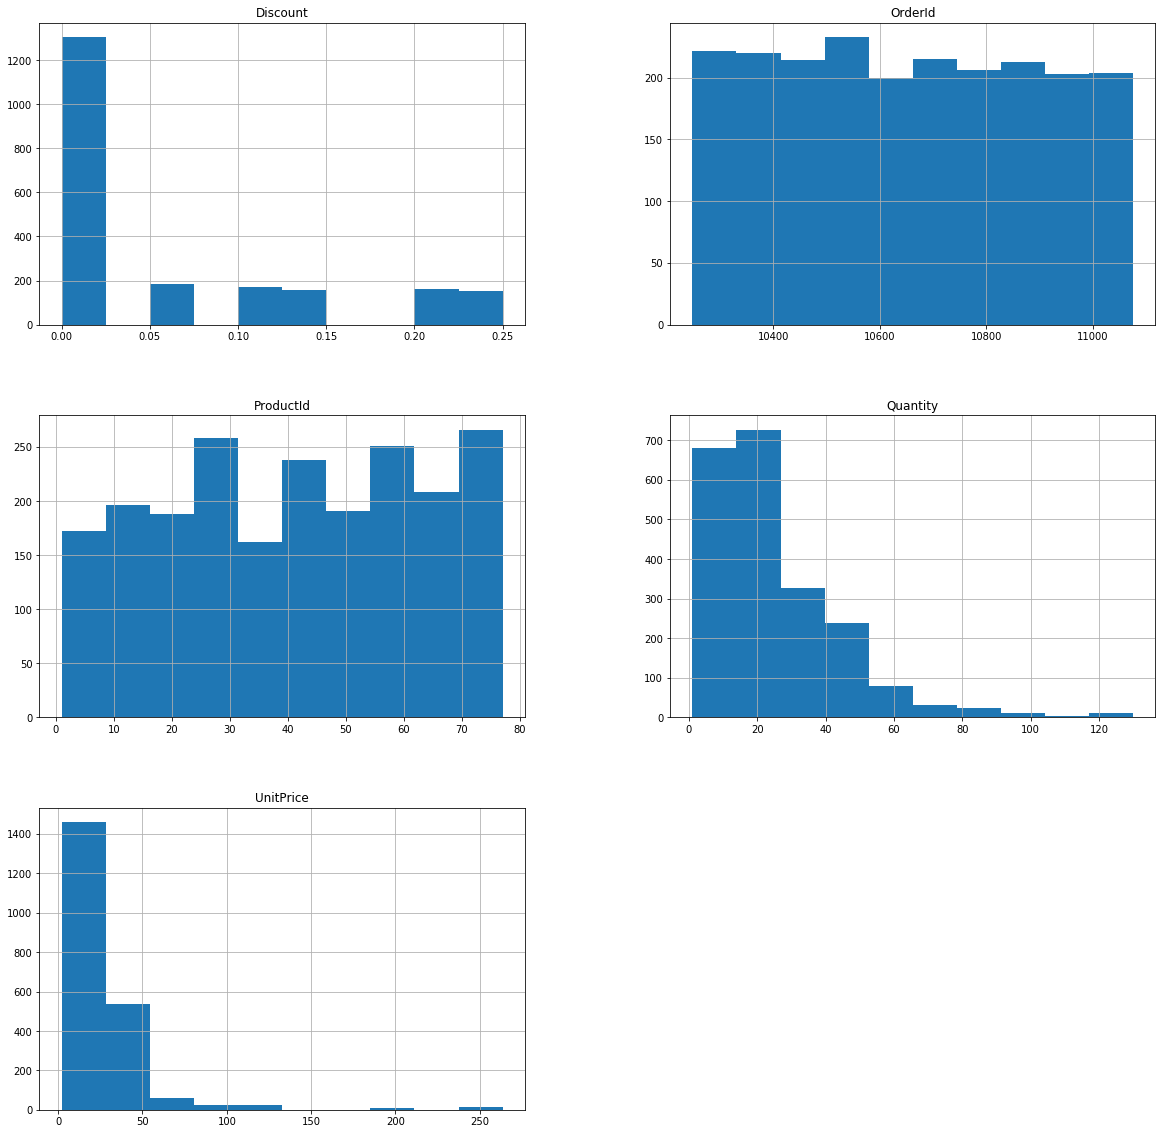

In [19]:
df_drop.hist(figsize=(20,20));

### Setting up for testing

We need to set up our two samples for the 2 sample t-test. All of the data without a discount will be lumped into one sample, and all of the data with some form of discount will make up the other sample.

In [20]:
# no discount applied
cur.execute("""SELECT *
               FROM OrderDetail
               WHERE Discount is 0
               """)
df_no_discount = pd.DataFrame(cur.fetchall())
df_no_discount.columns = [x[0] for x in cur.description]
df_no_discount

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.0
1,10248/42,10248,42,9.80,10,0.0
2,10248/72,10248,72,34.80,5,0.0
3,10249/14,10249,14,18.60,9,0.0
4,10249/51,10249,51,42.40,40,0.0
...,...,...,...,...,...,...
1312,11077/52,11077,52,7.00,2,0.0
1313,11077/55,11077,55,24.00,2,0.0
1314,11077/66,11077,66,17.00,1,0.0
1315,11077/75,11077,75,7.75,4,0.0


In [21]:
grouped_no_discount = df_no_discount.groupby(['OrderId', 'ProductId', 'Quantity'])['Discount'].sum()
grouped_no_discount

OrderId  ProductId  Quantity
10248    11         12          0.0
         42         10          0.0
         72         5           0.0
10249    14         9           0.0
         51         40          0.0
                               ... 
11077    52         2           0.0
         55         2           0.0
         66         1           0.0
         75         4           0.0
         77         2           0.0
Name: Discount, Length: 1317, dtype: float64

(array([   0.,    0.,    0.,    0.,    0., 1317.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

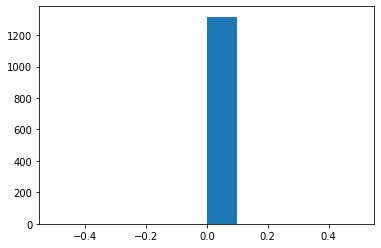

In [22]:
# histogram for discount
plt.hist(grouped_no_discount)

(array([487., 438., 197., 126.,  39.,  11.,   8.,   4.,   3.,   4.]),
 array([  1. ,  13.9,  26.8,  39.7,  52.6,  65.5,  78.4,  91.3, 104.2,
        117.1, 130. ]),
 <a list of 10 Patch objects>)

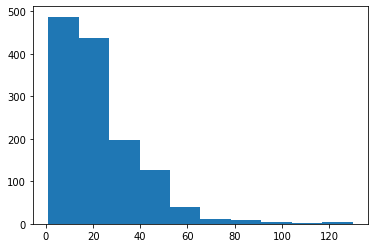

In [23]:
# histogram for quantity
plt.hist(df_no_discount['Quantity'])

In [24]:
# discount applied
cur.execute("""SELECT *
               FROM OrderDetail
               WHERE Discount is not 0
               """)
df_discount = pd.DataFrame(cur.fetchall())
df_discount.columns = [x[0] for x in cur.description]
df_discount

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.40,35,0.15
1,10250/65,10250,65,16.80,15,0.15
2,10251/22,10251,22,16.80,6,0.05
3,10251/57,10251,57,15.60,15,0.05
4,10252/20,10252,20,64.80,40,0.05
...,...,...,...,...,...,...
833,11077/39,11077,39,18.00,2,0.05
834,11077/46,11077,46,12.00,3,0.02
835,11077/60,11077,60,34.00,2,0.06
836,11077/64,11077,64,33.25,2,0.03


In [25]:
grouped_discount = df_discount.groupby(['OrderId', 'ProductId', 'Quantity'])['Discount'].sum()
grouped_discount

OrderId  ProductId  Quantity
10250    51         35          0.15
         65         15          0.15
10251    22         6           0.05
         57         15          0.05
10252    20         40          0.05
                                ... 
11077    39         2           0.05
         46         3           0.02
         60         2           0.06
         64         2           0.03
         73         2           0.01
Name: Discount, Length: 838, dtype: float64

(array([  6., 186.,   1., 173.,   0., 157.,   0., 161.,   0., 154.]),
 array([0.01 , 0.034, 0.058, 0.082, 0.106, 0.13 , 0.154, 0.178, 0.202,
        0.226, 0.25 ]),
 <a list of 10 Patch objects>)

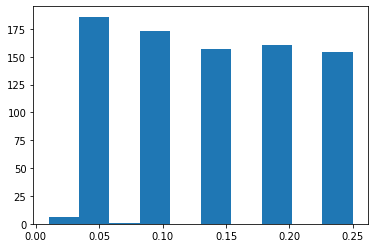

In [26]:
# histogram for discount
plt.hist(grouped_discount)

(array([218., 290., 129., 112.,  41.,  21.,  15.,   6.,   0.,   6.]),
 array([  1. ,  13.9,  26.8,  39.7,  52.6,  65.5,  78.4,  91.3, 104.2,
        117.1, 130. ]),
 <a list of 10 Patch objects>)

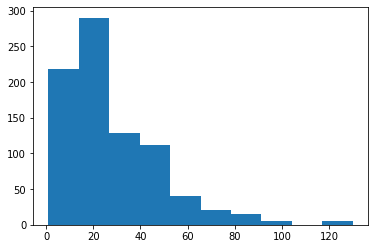

In [27]:
# histogram for quantity
plt.hist(df_discount['Quantity'])

# Testing

## 2 Sample T-Test

### Setting up variables

In [28]:
# calculating the t statistic (doing on 'paper' to confirm that the data is organized correctly before running test)
alpha = 0.05
x_bar_no_discount = df_no_discount['Quantity'].mean()
x_bar_discount = df_discount['Quantity'].mean()
sigma_no_discount = df_no_discount['Quantity'].std()
sigma_discount = df_discount['Quantity'].std()
n_no_discount = len(df_no_discount['Quantity'])
n_discount = len(df_discount['Quantity'])
mu_discount = mu_no_discount = 100
dof = n_discount - 1
t = ((x_bar_no_discount-x_bar_discount) - (mu_no_discount-mu_discount)) / np.sqrt((sigma_no_discount**2/n_no_discount) + (sigma_discount**2/n_discount))
t

-6.239069142123973

In [29]:
# test
statistic, pvalue = stats.ttest_ind(df_no_discount['Quantity'], df_discount['Quantity'])

In [30]:
# result
pvalue

1.1440924523215966e-10

In [31]:
# evaluation of results
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


This means means that discount has a statistically significant effect on quantity of a product in an order, tentatively. This needs to be explored a little bit further to verify that this is the case, and that our results are valid. To verfiy results, we'll run a Mann Whitney to ensure that this is the case for non-parametric data as well. Our histograms for quantity were skewed right, so there is a chance that the data is non-paramentric. Then we will run a test on effect size to ensure that we have enough data points to declare statistical significance.

# Digging Deeper

## Mann Whitney Test

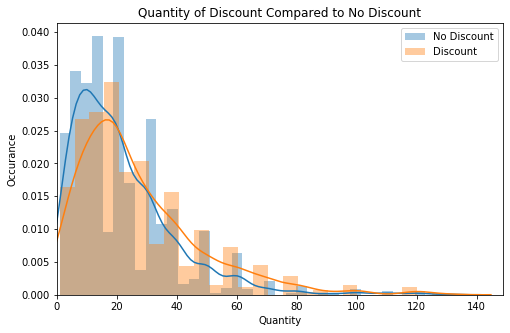

In [50]:
# visualizing the data
fig03 = plt.figure(figsize=(8,5))
ax = fig03.add_subplot(111)
ax.axes.set_title('Quantity of Discount Compared to No Discount')
ax.axes.set_ylabel('Occurance')
ax.axes.set_xlabel('Quantity')
ax1 = sns.distplot(df_no_discount['Quantity'], label=('No Discount'), ax=ax).set_xlim(0)
ax2 = sns.distplot(df_discount['Quantity'], label=('Discount'), ax=ax).set_xlim(0)
ax.axes.legend();

In [51]:
# mann whitney test
statistice, pvalue = stats.mannwhitneyu(df_no_discount['Quantity'], df_discount['Quantity'])

In [52]:
# result
pvalue

6.629381826999866e-11

In [54]:
# evaluating the result
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


This confirms that even with non-parametric data, the same rejection of the null hypothesis is in place, meaning that the availablity of a discount affects quantity ordered. Now to see how large the impact of a discount is. Then to see how many samples are needed to ensure valid results.

## Effect size -- Cohen's D

In [55]:
def cohen_d_two_samp(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)
effect_size = cohen_d_two_samp(df_no_discount['Quantity'], df_discount['Quantity'])
effect_size

-0.2862776476697576

This Cohen's D value actually is very low. There a very small affect of discount on quantity of products purchased.

## Power

In [56]:
# prepping variables
effect_size, nobs1, alpha = effect_size, df_no_discount['Quantity'].shape[0], alpha

In [57]:
# power test
power = tt_ind_solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha)
power

1.0

In [58]:
# results
type_2_error = 1 - power
type_2_error

0.0

Since there is nominal chance for a type 2 error in which we reject the null hypothesis when we are not supposed to, I am fairly confident that our null hypothesis has been rejected indicating that discount has a present, but small, affect on quantity purchased in an order. The next step is to determine if the level of discount influences quantity purchased. We will do this by using an ANOVA.

## One Way ANOVA

### H0: quantity of order is not affected by discount size, meaning all discounts for quantity ordered are the same
### HA: quantity of order is affected by discount size, meaning at least one discount impacts quantity ordered

### Looking at the necessary data to identify discount levels

A small note about the decision to drop order# 11077 from the dataset to remove the 1, 2, 3, 4, and 6 percent discounts.

In [59]:
# discount amount reminder from original data
cur.execute("""SELECT DISTINCT(Discount)
               FROM OrderDetail
               """)
df_distint_discount = pd.DataFrame(cur.fetchall())
df_distint_discount.columns = [x[0] for x in cur.description]
df_distint_discount['Discount']

0     0.00
1     0.15
2     0.05
3     0.20
4     0.25
5     0.10
6     0.02
7     0.03
8     0.04
9     0.06
10    0.01
Name: Discount, dtype: float64

In [60]:
# variables are prepped from the original data frame
anova_df = df_drop[df_drop['Discount']!=0]
anova_df.head(15)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05
12,10252/33,10252,33,2.0,25,0.05
17,10254/24,10254,24,3.6,15,0.15
18,10254/55,10254,55,19.2,21,0.15
29,10258/2,10258,2,15.2,50,0.20
30,10258/5,10258,5,17.0,65,0.20


In [61]:
# ANOVA test
anova_results = sm.stats.anova_lm(ols('Quantity ~ Discount', data=anova_df).fit())
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
Discount,1.0,18.503014,18.503014,0.043107,0.835576
Residual,823.0,353261.492138,429.236321,NaN,NaN


In [62]:
# results
pvalue = anova_results.loc['Discount', 'PR(>F)']

In [63]:
# evaluating results
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


Due to the ANOVA test, quantity of order is not affected by discount size. This means that overall, just by offering a discount at all quantity of the products ordered will increase. But it does not seem that offering larger discounts incentivizes increased spending by increasing the quantities ordered.

# Actionable Items and Insights

It might be wise to offer more customers smaller discounts to increased quantities of products in orders. Do note that this impact while present, will not be large. I would look for additional ways to increase customer spending in addition to offering smaller discounts to a wider range of customers. 

C:\Users\eannefawcett\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


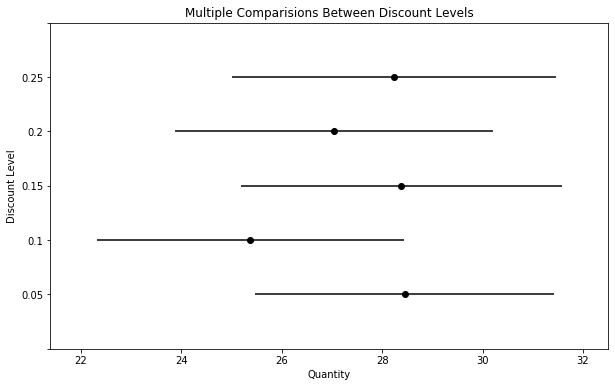

In [72]:
# visual of no differences
fig04 = plt.figure(figsize=(8,5))
ax = fig04.add_subplot(111)


from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(anova_df['Quantity'], anova_df['Discount'])
tukey_plot = tukey_results.plot_simultaneous(ax=ax).show() 
# explore .plot_simultaneous compare documentation
ax.axes.set_title('Multiple Comparisions Between Discount Levels')
ax.axes.set_ylabel('Discount Level')
ax.axes.set_xlabel('Quantity')
plt.show();